# ns_solar_echelle
notebook for making echelle diagram from grid point. examples for:
- true values from grid
- true values compared to values taken from random draws of obs noise
- true values compared to neural network predicted values for corresponding model inps

In [48]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_v2 import WMSE
from pitchfuncs_v2 import InversePCA
from pitchfuncs_v2 import emulator
from pitchfuncs_v2 import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import json


def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


In [286]:
hare = pd.read_json("solar_hare2.json")
outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]
hare_true = hare[outputs]
hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
4098711,1,0.013508,0.24,1.9,4.605898,0.993668,0.904566,5650.91516,-0.0558,684.334509,...,0.727786,0.729035,0.730063,0.729626,0.730431,0.730403,0.729293,0.727165,0.724994,-0.345785


## 1) true values from grid
all freqs:

In [434]:
def echelle_plot(model, dnu=0, n_min=6, n_max=40, x_scale=True,**kwargs):
    freqs = model[[f'nu_0_{i}' for i in range(n_min,n_max+1)]]
    
    if dnu == 0:
        dnu = np.median(freqs.values[0][1:]-freqs.values[0][:-1])

    echelle_y = freqs.values[0]
    echelle_x = freqs.values[0]%dnu
    
    plt.scatter(echelle_x, echelle_y, **kwargs)

    if x_scale:
        plt.xlim([0,dnu])

    return dnu

136.94605992130005

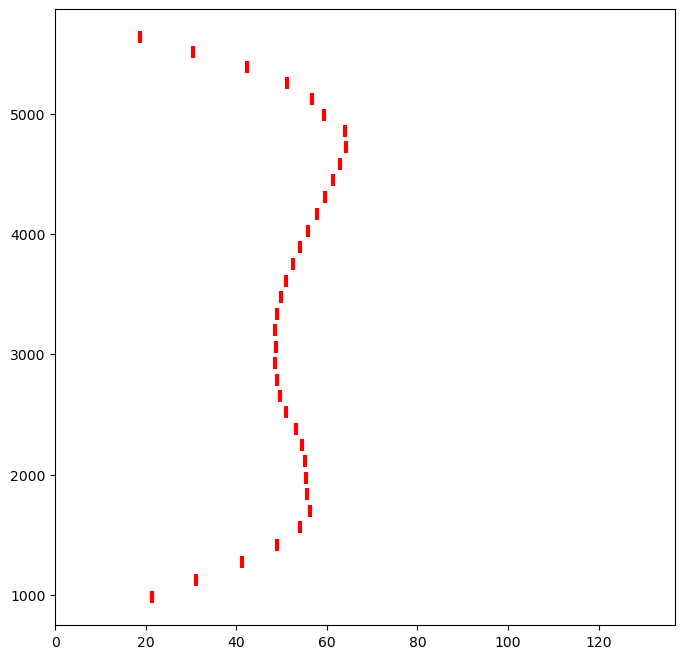

In [436]:
plt.figure(figsize=(8,8))
echelle_plot(hare,marker='|', color='red', s=80, linewidth=3)

radial orders 15-25:

136.72688997670002

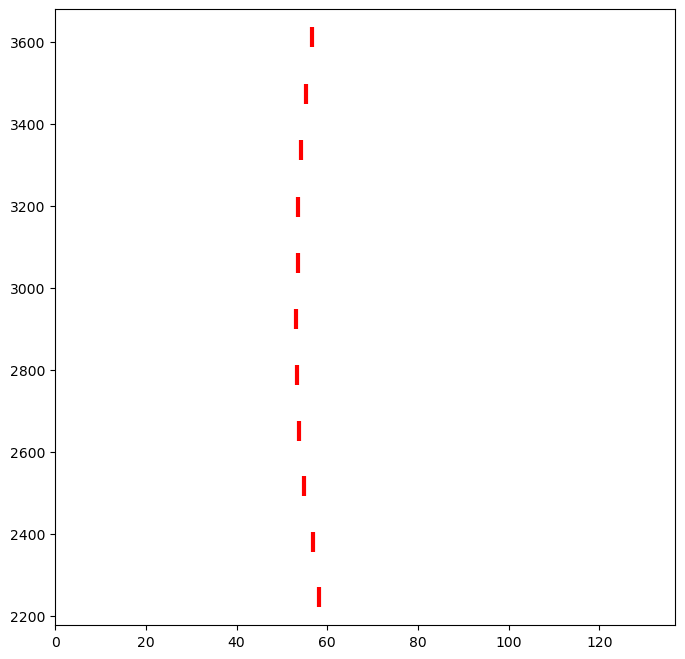

In [439]:
plt.figure(figsize=(8,8))
echelle_plot(hare, n_min=15, n_max=25,marker='|', color='red', s=200, linewidth=3)

## 2) true compared to draws from obs noise

In [455]:
teff_unc = 70 #K
luminosity_unc = 0.02 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.05 #\muHz

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc + (0.05*np.abs(23-i)) for i in range(6,41)])
obs_unc

array([7.0e+01, 2.0e-02, 1.0e-01, 9.0e-01, 8.5e-01, 8.0e-01, 7.5e-01,
       7.0e-01, 6.5e-01, 6.0e-01, 5.5e-01, 5.0e-01, 4.5e-01, 4.0e-01,
       3.5e-01, 3.0e-01, 2.5e-01, 2.0e-01, 1.5e-01, 1.0e-01, 5.0e-02,
       1.0e-01, 1.5e-01, 2.0e-01, 2.5e-01, 3.0e-01, 3.5e-01, 4.0e-01,
       4.5e-01, 5.0e-01, 5.5e-01, 6.0e-01, 6.5e-01, 7.0e-01, 7.5e-01,
       8.0e-01, 8.5e-01, 9.0e-01])

In [456]:
def obs_noise(true, unc, seed=42):
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=seed)
        idx+=1

    return noisy_obs

hare_obs = dict(zip(outputs,obs_noise(hare_true.values[0],obs_unc, seed=13)))
hare_obs = pd.DataFrame.from_dict([hare_obs])
hare_obs

,calc_effective_T,luminosity,star_feh,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
0,5597.108749,0.890318,-0.127039,979.440876,1126.021429,1273.163698,1417.831498,1559.978505,1699.101401,1835.488672,...,4443.378562,4581.850644,4719.991918,4856.68981,4988.994716,5123.167119,5254.525632,5382.596067,5507.759585,5632.825318


136.94605992130005

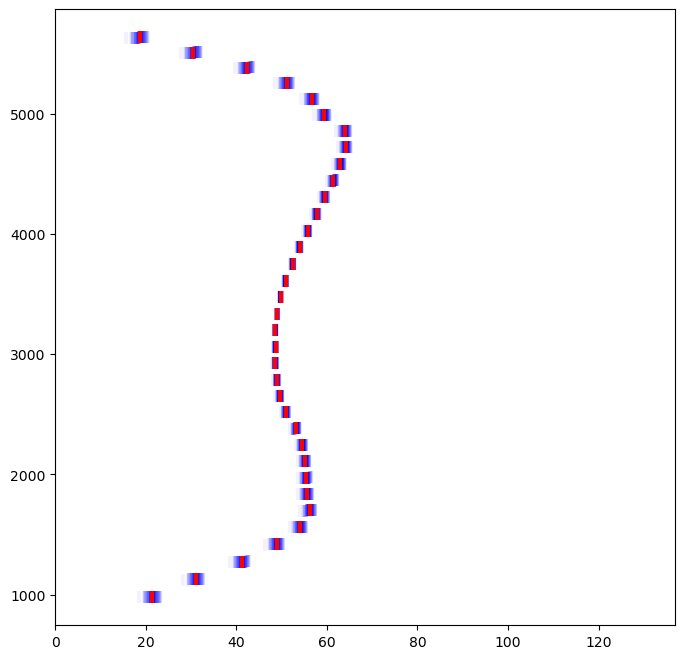

In [457]:
hare_obs = dict(zip(outputs,obs_noise(hare_true.values[0],obs_unc, seed=42)))
hare_obs = pd.DataFrame.from_dict([hare_obs])

plt.figure(figsize=(8,8))
dnu = echelle_plot(hare,marker='|', color='red', s=80, linewidth=3)

seeds = list(np.arange(1,100,1))
for seed in seeds:
    hare_obs = dict(zip(outputs,obs_noise(hare_true.values[0],obs_unc, seed=seed)))
    hare_obs = pd.DataFrame.from_dict([hare_obs])
    echelle_plot(hare_obs, dnu=dnu, marker='|',color='blue', s=80, linewidth=3,alpha=0.05, x_scale=False)

echelle_plot(hare,marker='|', color='red', s=80, linewidth=3)

136.72688997670002

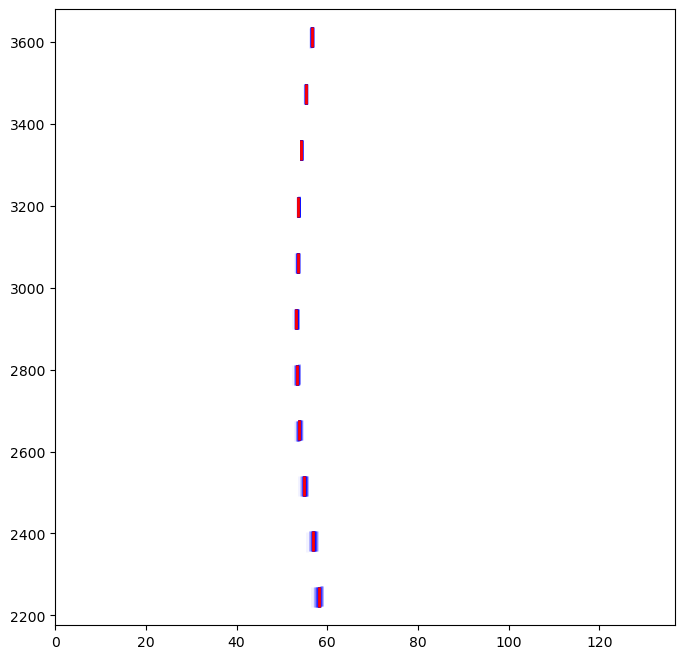

In [471]:
hare_obs = dict(zip(outputs,obs_noise(hare_true.values[0],obs_unc, seed=42)))
hare_obs = pd.DataFrame.from_dict([hare_obs])

plt.figure(figsize=(8,8))
dnu = echelle_plot(hare, n_min=15, n_max=25, marker='|', color='red', s=200, linewidth=2)

seeds = list(np.arange(1,100,1))
for seed in seeds:
    hare_obs = dict(zip(outputs,obs_noise(hare_true.values[0],obs_unc, seed=seed)))
    hare_obs = pd.DataFrame.from_dict([hare_obs])
    echelle_plot(hare_obs, n_min=15, n_max=25, dnu=dnu, marker='|',color='blue', s=200, linewidth=2,alpha=0.05, x_scale=False)

echelle_plot(hare, n_min=15, n_max=25,marker='|', color='red', s=200, linewidth=2)

## 2) true compared to predicted

In [472]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [473]:
inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

hare_preds = pitchfork.predict([hare_inps.values[0]])

hare_preds = dict(zip(outputs,hare_preds[0]))
hare_preds = pd.DataFrame.from_dict([hare_preds])
hare_preds

,calc_effective_T,luminosity,star_feh,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
0,5647.236897,0.905399,-0.056037,979.864067,1127.209941,1273.219439,1418.539757,1560.881564,1699.397448,1836.024068,...,4444.763172,4582.977977,4719.796498,4855.718949,4990.931738,5124.595272,5255.34052,5382.762103,5508.240146,5634.056735


136.94605992130005

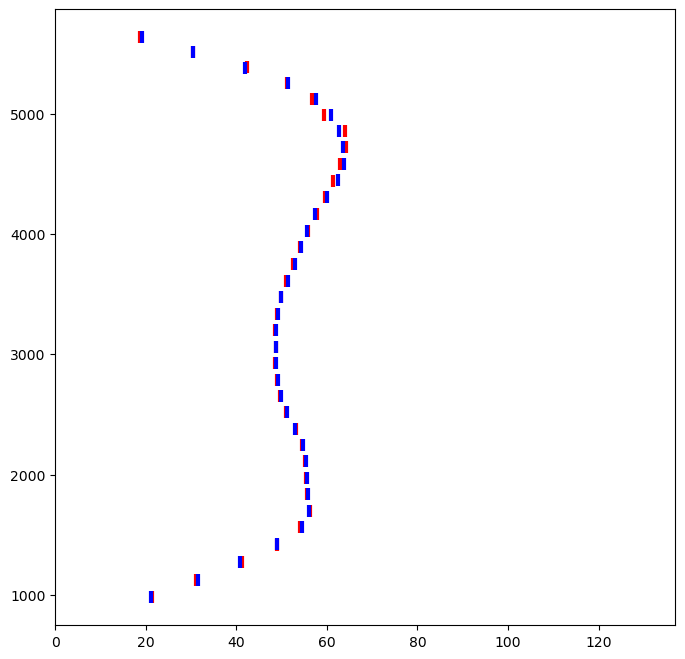

In [474]:
plt.figure(figsize=(8,8))
dnu = echelle_plot(hare,marker='|', color='red', s=80, linewidth=3)
echelle_plot(hare_preds,dnu=dnu,marker='|', color='blue', s=80, linewidth=3)

136.72688997670002

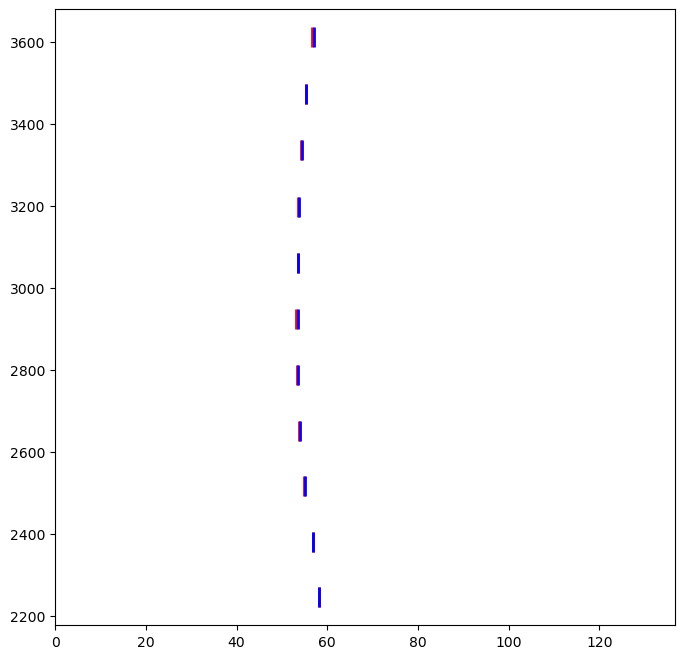

In [475]:
plt.figure(figsize=(8,8))
dnu = echelle_plot(hare,n_min=15, n_max=25,marker='|', color='red', s=200, linewidth=2)
echelle_plot(hare_preds,dnu=dnu,n_min=15, n_max=25, marker='|', color='blue', s=200, linewidth=2)